# Movie Recommendation Engine 

## Akhil Kumar Ramasagaram | Sai Prashanth Puligilla 

In [1]:
import pandas as pd
import numpy as np
u_data = pd.read_table("ml-100k/u.data", delimiter= "\t", names=["User.ID","Movie.ID","Ratings","Time"])
u_data.head(6)

,User.ID,Movie.ID,Ratings,Time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806


In [2]:
spm = pd.read_csv("ml-100k/spm.csv")

In [3]:
u_item = pd.read_table("ml-100k/u.item", delimiter="|", 
                       names=["ID", "Title", "ReleaseDate", "VideoReleaseDate", "IMDB", "Unknown", 
                              "Action", "Adventure", "Animation", "Childrens", "Comedy", "Crime", 
                              "Documentary", "Drama", "Fantasy", "FilmNoir", "Horror", "Musical", 
                              "Mystery", "Romance", "SciFi", "Thriller", "War", "Western"])
spm.columns = u_item['Title']

## User based Collaborative Filtering

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
def recommend_user(x, verbose = False):
    target_user = np.array(spm.iloc[x,:])
    user_similarity = np.repeat(1.0,spm.shape[0])
    for i in range(spm.shape[0]):
        user_similarity[i] = cosine_similarity(spm.iloc[i,:], target_user)
    unrated_movies = np.where(target_user == 0)[0]
    rated_movies = target_user.nonzero()[0]
    ur_movies = spm.iloc[:,unrated_movies]
    weighted_matrix = pd.DataFrame(columns= ur_movies.columns, 
                                   index = np.arange(ur_movies.shape[0]))
    for i in range(len(user_similarity)):
        weighted_matrix.iloc[i,:] = user_similarity[i] * ur_movies.iloc[i,:]
    total_movie_rating = weighted_matrix.sum(axis=0)
    users_rated = pd.DataFrame(index=np.arange(len(weighted_matrix)), columns=['temp'])
    for i in range(weighted_matrix.shape[1]):
        temp_ind = np.where(weighted_matrix.iloc[:,i] > 0)[0]
        users_rated['temp'][i] = sum(user_similarity[temp_ind])
    users_rated = np.array(users_rated['temp'])
    for i in (np.where(users_rated == 0)):
        users_rated[i] = float('NaN')
    predict_ratings = total_movie_rating/users_rated
    predict_ratings.columns = spm.iloc[:,unrated_movies].columns
    ordered_ind = list(reversed(np.argsort(predict_ratings)[slice(-5, None)]))
    top_5_ind = ordered_ind[:5]
    user_rated_movies = target_user[rated_movies]
    movies_predicted = predict_ratings[rated_movies]
    accuracy = sum(abs(user_rated_movies - movies_predicted)/len(rated_movies))
    if(verbose == True):
        print("The Mean Accuracy Error is: %.5f" %accuracy)
        print("Top 5 Recommended Movies are")
        final = predict_ratings[top_5_ind]
        final = pd.Series.to_frame(final)
        for i in range(5):
            print(final.index.values[i])
    else:
        return(accuracy)
recommend_user(1,False)

1.0310972090819936

## Iterm Based Collaborative Filtering 

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
movies_sim = pd.DataFrame(cosine_similarity(spm.T))
movies_sim.columns = u_item['Title']


In [6]:
samp = movies_sim
for i in range(samp.shape[1]):
    samp.iloc[:,i] = np.array(list(reversed(np.argsort(movies_sim.iloc[:,i]))))


In [7]:
def recommend_user_ib(x, verbose = False):
    target_user = np.array(spm.iloc[x,:])
    rated_movies = target_user.nonzero()[0]
    unrated_movies = np.where(target_user == 0)[0]
    predictions = pd.DataFrame(index = np.arange(1), columns=spm.columns)
    for i in range(spm.shape[1]):
        top_20_similar_movies = samp.iloc[1:20,i]
        ratings = max(spm.iloc[x,top_20_similar_movies])
        predictions.iloc[0,i] = ratings
    p_order = predictions.iloc[:,unrated_movies]
    p_order = p_order.transpose()
    p_order.columns = ['Ratings']
    rated_movies_ac = spm.iloc[47,rated_movies]
    pred_movies_ac = p_order['Ratings'].convert_objects(convert_numeric=True)
    p_order = p_order.sort(columns='Ratings', ascending=False)
    final_movies = p_order.iloc[0:5,:].index.tolist()
    accuracy = sum(abs(np.array(rated_movies_ac) - np.array(pred_movies_ac[rated_movies])))/float(len(rated_movies))
    if(verbose == True):
        for i in range(5):
            print(final_movies[i])
        print("The Mean Accuracy Error is: %.5f" %accuracy)
    else:
        return(accuracy)

recommend_user_ib(8,False)

2.1818181818181817

### Evaluating IB & UB Collaborative Filterring  

In [8]:
sample_user_ids = np.array([4,8,48])
IB_mse = []
UB_mse = []
for i in sample_user_ids:
    print(i)
    IB_mse.append(recommend_user_ib(i,False))
    UB_mse.append(recommend_user(i,False))
print(np.mean(IB_mse))
print(np.mean(UB_mse))

4
8
48
2.61692942716
1.2088106161


### Clsutering

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
u_item.drop(u_item.columns[[0,2,3,4]], axis=1, inplace=True)
u_item.drop_duplicates(cols = 'Title', inplace = True)
distances = pd.DataFrame(cosine_similarity(u_item.iloc[:,1:]))
Z = linkage(distances, 'complete')
clusters = fcluster(Z, 10, criterion='maxclust')

/Users/akhil/.graphlab/anaconda/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead
  warnings.warn(msg, FutureWarning)


In [10]:
def recommend_user_clust(x):
    user = spm.iloc[x,:]
    temp = np.array(user)
    highest_rated_movie = np.where(temp==max(user))
    cg = clusters[highest_rated_movie]
    uniq_clusters = np.unique(cg)
    clust_group = pd.value_counts(pd.Series(cg))[0:2]
    best_clust = clust_group.index
    temp_ind = []
    for i in best_clust:
        t_ind = list(np.where(clusters == i)[0])
        temp_ind += t_ind
    cluster_subset = u_item.iloc[temp_ind,:]
    print("Based on User ratings, we found %d movies" %cluster_subset.shape[0])
    genre_summary = pd.DataFrame(cluster_subset.sum(numeric_only=True),columns=['Freq'])
    print('Most suited genre: %s' %genre_summary.sort(columns="Freq", ascending=False).index[0])
    rand_rec = np.random.randint(cluster_subset.shape[0], size = 5)
    for i in rand_rec:
        print(cluster_subset.iloc[i,0])

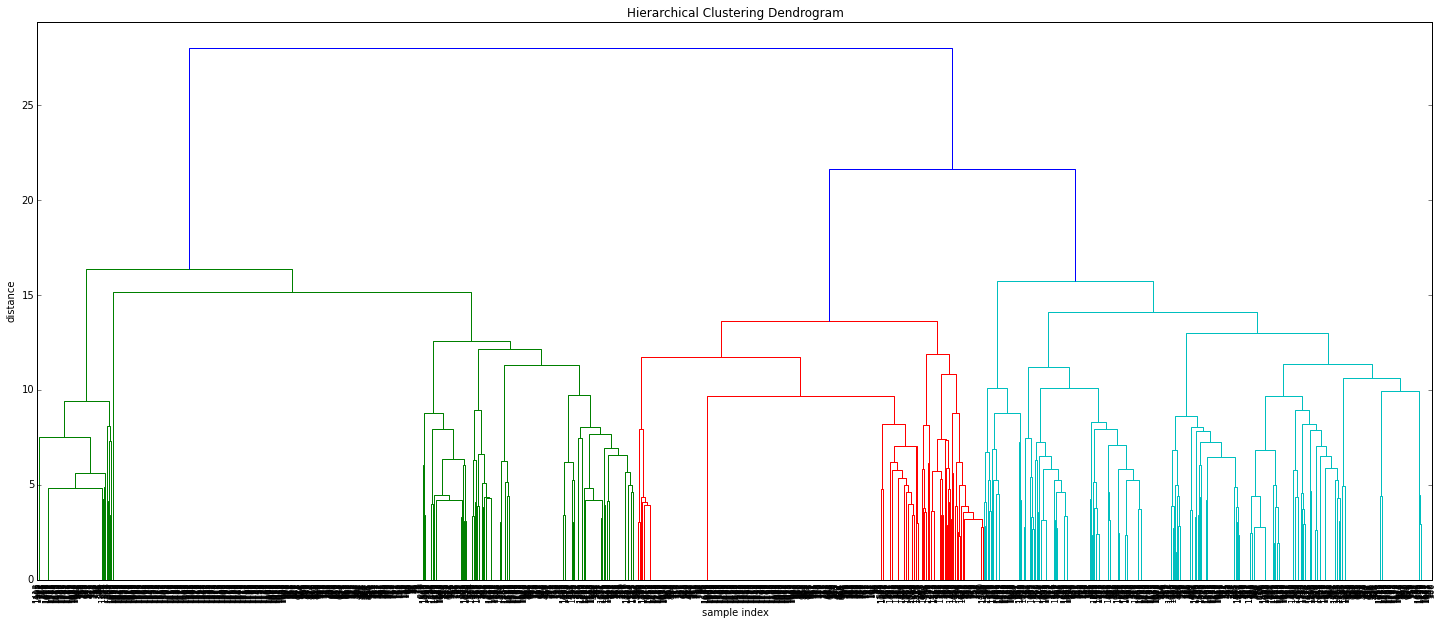

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [12]:
spm.iloc[4,np.where(np.array(spm.iloc[4,:]) != 0)]

Title
Toy Story (1995)                                           4
GoldenEye (1995)                                           3
From Dusk Till Dawn (1996)                                 4
Muppet Treasure Island (1996)                              3
Rumble in the Bronx (1995)                                 4
Birdcage, The (1996)                                       3
Batman Forever (1995)                                      4
To Wong Foo, Thanks for Everything! Julie Newmar (1995)    4
Clerks (1994)                                              5
Star Wars (1977)                                           4
Stargate (1994)                                            4
Santa Clause, The (1994)                                   1
While You Were Sleeping (1995)                             1
Forrest Gump (1994)                                        1
Four Weddings and a Funeral (1994)                         4
Fugitive, The (1993)                                       3
Hot Shots! Part De

In [13]:
recommend_user(4,True)

The Mean Accuracy Error is: 1.16921
Top 5 Recommended Movies are
Last Summer in the Hamptons (1995)
Prefontaine (1997)
Celtic Pride (1996)
Twin Town (1997)
Great Day in Harlem, A (1994)


In [14]:
recommend_user_ib(4,True)

Full Monty, The (1997)
Heat (1995)
Sense and Sensibility (1995)
Leaving Las Vegas (1995)
Restoration (1995)
The Mean Accuracy Error is: 2.84571


In [15]:
recommend_user_clust(4)

Based on User ratings, we found 558 movies
Most suited genre: Comedy
Only You (1994)
Gordy (1995)
Amityville Horror, The (1979)
Dunston Checks In (1996)
Phat Beach (1996)


Based on the movies the above user rated, we did a quick search on some of the movies on IMDB and we found that some of these movies are fall in Comedy, Action & Drama mostly. If you Look at the recommendations generated from the UB, IB and clustering we can see some similar recommendations. 